In [41]:
import pandas as pd
import numpy as np
import sys, os, shutil
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, roc_auc_score, make_scorer
import mlflow
from mlflow.models import infer_signature
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import xgboost as xgb
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from mlflow.models.signature import infer_signature
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
hotel_bookings_train_data = pd.read_csv('hotel_bookings_training.csv')
print(hotel_bookings_train_data.shape)
hotel_bookings_train_data.head()

(118660, 35)


,booking_id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,booking_date
0,0,Resort Hotel,0,342,2015,July,27,1,0,0,...,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,2014-07-24
1,1,Resort Hotel,0,737,2015,July,27,1,0,0,...,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,2013-06-24
2,2,Resort Hotel,0,7,2015,July,27,1,0,1,...,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,2015-06-24
3,3,Resort Hotel,0,13,2015,July,27,1,0,1,...,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,2015-06-18
4,4,Resort Hotel,0,14,2015,July,27,1,0,2,...,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,2015-06-17


In [3]:
hotel_bookings_train_data.isna().sum()

booking_id                             0
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent           

In [4]:
hotel_bookings_train_data['agent'].fillna(0, inplace=True) # added extra

In [5]:
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy() 

        X = X.drop(X.columns[0], axis=1)
        X.fillna(-1, inplace=True)
        filter = (X['children'] == 0) & (X['adults'] == 0) & (X['babies'] == 0)
        X = X[~filter]
        useless_col = ['days_in_waiting_list', 'arrival_date_year', 'assigned_room_type', 'booking_changes',
                       'reservation_status', 'country', 'days_in_waiting_list']
        X.drop(useless_col, axis=1, inplace=True)
        X["arrival_date"] = pd.to_datetime(X["arrival_date"])
        X["booking_date"] = pd.to_datetime(X["booking_date"])

        cat_cols = [col for col in X.columns if X[col].dtype == 'O']
        cat_df = X[cat_cols]

        if 'reservation_status_date' in cat_df:
            cat_df['reservation_status_date'] = pd.to_datetime(cat_df['reservation_status_date'])
            cat_df['year'] = cat_df['reservation_status_date'].dt.year
            cat_df['month'] = cat_df['reservation_status_date'].dt.month
            cat_df['day'] = cat_df['reservation_status_date'].dt.day
            cat_df.drop(['reservation_status_date', 'arrival_date_month'], axis=1, inplace=True)

        mappings = {
            'hotel': {'Resort Hotel': 0, 'City Hotel': 1},
            'meal': {'BB': 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4},
            'market_segment': {'Direct': 0, 'Corporate': 1, 'Online TA': 2, 'Offline TA/TO': 3,
                               'Complementary': 4, 'Groups': 5, 'Undefined': 6, 'Aviation': 7},
            'distribution_channel': {'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3,
                                     'GDS': 4},
            'reserved_room_type': {'C': 0, 'A': 1, 'D': 2, 'E': 3, 'G': 4, 'F': 5, 'H': 6,
                                   'L': 7, 'B': 8},
            'deposit_type': {'No Deposit': 0, 'Refundable': 1, 'Non Refund': 3},
            'customer_type': {'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3},
            'year': {2015: 0, 2014: 1, 2016: 2, 2017: 3}
        }

        for col, mapping in mappings.items():
            if col in cat_df:
                cat_df[col] = cat_df[col].map(mapping)
                cat_df[col] = cat_df[col].fillna(-1)

        num_df = X.select_dtypes(include=['int64', 'float64'])
        #num_df.drop('is_canceled', axis=1, inplace=True)

        for col in ['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month', 'agent', 'adr']:
            if col in num_df:
                num_df[col] = np.log(num_df[col] + 1)

        X_transformed = pd.concat([cat_df, num_df], axis=1)
        X_transformed.fillna(0, inplace=True)

        return X_transformed

In [6]:
filter = (hotel_bookings_train_data['children'] == 0) & (hotel_bookings_train_data['adults'] == 0) & (hotel_bookings_train_data['babies'] == 0)
df_filtered = hotel_bookings_train_data[~filter]
X = df_filtered.drop('is_canceled', axis=1)
y = df_filtered['is_canceled']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X.columns

Index(['booking_id', 'hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'booking_date'],
      dtype='object')

## Trying Simple Models First

In [8]:
# trying different models and defining the respective pipelines

# shallow decision tree
params_dt = {
    'max_depth': 3,
    'min_samples_split': 2
}

dt = DecisionTreeClassifier(**params_dt)
pipe_dt = Pipeline(steps=[
    ('preprocessor', CustomPreprocessor()),
    ('dt', dt)
])

# random forest
params_rf = {
    'n_estimators': 100
}

rf = RandomForestClassifier(**params_rf)
pipe_rf = Pipeline(steps=[
    ('preprocessor', CustomPreprocessor()),
    ('rf', rf)
])

# xgboost
xgboost = xgb.XGBClassifier()
pipe_xgb = Pipeline(steps=[
    ('preprocessor', CustomPreprocessor()),
    ('xgb', xgboost)
])

#adaboost
adaboost = AdaBoostClassifier()
pipe_ada = Pipeline(steps=[
    ('preprocessor', CustomPreprocessor()),
    ('ada', adaboost)
])

pipelines = [pipe_dt, pipe_rf, pipe_xgb, pipe_ada]

### Logging the simple models in MLFlow

In [10]:
mlflow.set_tracking_uri(uri="http://localhost:9080")
experiment_name = "baseline_models"

# Check if the experiment already exists, if not, create a new one
try:
    experiment_orig_id = mlflow.create_experiment(experiment_name)
except mlflow.exceptions.MlflowException:
    experiment_orig_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

# Print out the experiment ID for reference
print("Experiment ID:", experiment_orig_id)

Experiment ID: 930259693027444821


In [11]:
run_infos = []

for pipeline in pipelines:
    with mlflow.start_run(experiment_id=experiment_orig_id, nested=True):
        model_name = pipeline[-1].__class__.__name__
        mlflow.log_param('model_name', model_name)
        model_params = pipeline[-1].get_params()
        metric_names = ['accuracy', 'f1', 'precision', 'recall']
        pipeline.fit(X_train, y_train)
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)
        
        train_report = classification_report(y_train, y_train_pred, output_dict=True)
        training_metrics = {
            'Accuracy': round(train_report['accuracy'], 3),
            'F1': round(train_report['macro avg']['f1-score'], 3),
            'Precision': round(train_report['macro avg']['precision'], 3),
            'Recall': round(train_report['macro avg']['recall'], 3)
        }
        training_metrics_values = list(training_metrics.values())

        test_report = classification_report(y_test, y_test_pred, output_dict=True)
        testing_metrics = {
            'Accuracy': round(test_report['accuracy'], 3),
            'F1': round(test_report['macro avg']['f1-score'], 3),
            'Precision': round(test_report['macro avg']['precision'], 3),
            'Recall': round(test_report['macro avg']['recall'], 3)
        }
        testing_metrics_values = list(testing_metrics.values())
    
        model_info = mlflow.sklearn.log_model(
            pipeline,
            'model',
            input_example=X_train 
        )

        # Log each metric
        for name, metric in list(zip(metric_names, training_metrics_values)):
            mlflow.log_metric(f'training_{name}', metric)
        for name, metric in list(zip(metric_names, testing_metrics_values)):
            mlflow.log_metric(f'test_{name}', metric)
        
        # Log each hyper-parameter
        for param_name, param_value in model_params.items():
            mlflow.log_param(param_name, param_value)

        print(model_info.model_uri)
        run_infos.append(model_info.model_uri)
        print(pipeline.steps[-1][0], 'done')
        print('======================\n')

runs:/849e364a62594a62871073860736d048/model
dt done

runs:/f0fff373906d4025969ad4e7a46512ec/model
rf done

runs:/3d87a868dae44549bf4d0e928b88a9b4/model
xgb done

runs:/9922186b5a8d408b98d77b9f92d8c5fb/model
ada done



In [12]:
# [OPTIONAL] finding the best fine-tuned model based on f1 score
# runs = mlflow.search_runs(experiment_ids=[experiment_orig_id])

# best_orig_f1_score = -float('inf')
# best_orig_model = None
# best_orig_model_params = None
# best_orig_run_id = None

# for index, run in runs.iterrows():
#     run_id = run["run_id"]
#     with mlflow.start_run(run_id=run_id):
#         model_uri = f"runs:/{run_id}/model"
#         model = mlflow.sklearn.load_model(model_uri)
#         metrics = mlflow.get_run(run_id=run_id).data.metrics
        
#         if 'test_f1' in metrics:
#             run_f1_score = metrics['test_f1']
#             if run_f1_score > best_orig_f1_score:
#                 best_orig_f1_score = run_f1_score
#                 best_orig_model = model
#                 best_orig_model_params = mlflow.get_run(run_id=run_id).data.params
#                 best_orig_run_id = run_id

# print("Best F1 score:", best_orig_f1_score)
# print("Best model:", best_orig_model.steps[-1][0])
# # print("Best model parameters:", best_orig_model_params)
# print("Best run_id:", best_orig_run_id)

Best F1 score: 0.998
Best model: xgb
Best run_id: 3d87a868dae44549bf4d0e928b88a9b4


## Trying finetuning the 4 models

### Logging the different model versions during finetuning in MLFlow

In [22]:
mlflow.set_tracking_uri(uri="http://localhost:9080")
experiment_name = "finetuned_models"

# Check if the experiment already exists, if not, create a new one
try:
    experiment_id_finetune = mlflow.create_experiment(experiment_name)
except mlflow.exceptions.MlflowException:
    experiment_id_finetune = mlflow.get_experiment_by_name(experiment_name).experiment_id

# Print out the experiment ID for reference
print("Experiment ID:", experiment_id_finetune)

Experiment ID: 112110963367740946


In [14]:
param_hyperopt_dt = {
    'dt__max_depth': hp.choice('max_depth_dt', [3, 5, 7]),
    'dt__min_samples_split': hp.choice('min_samples_split_dt', [2, 5, 10]),
    'dt__min_samples_leaf': hp.choice('min_samples_leaf_dt', [1, 2, 4])
}

param_hyperopt_rf = {
    'rf__n_estimators': hp.choice('n_estimators_rf', [50, 100, 200]),
    'rf__max_depth': hp.choice('max_depth_rf', [None, 5, 10, 20]),
    'rf__min_samples_split': hp.choice('min_samples_split_rf', [2, 5, 10]),
    'rf__min_samples_leaf': hp.choice('min_samples_leaf_rf', [1, 2, 4])
}

param_hyperopt_xgb = {
    'xgb__max_depth': hp.choice('max_depth_xgb', [3, 4, 5, 6]),
    'xgb__learning_rate': hp.uniform('learning_rate_xgb', 0.01, 0.2),
    'xgb__n_estimators': hp.choice('n_estimators_xgb', [100, 200, 300])
}

param_hyperopt_ada = {
    'ada__n_estimators': hp.choice('n_estimators_ada', [50, 100, 200]),
    'ada__learning_rate': hp.uniform('learning_rate_ada', 0.01, 1.0),
    'ada__algorithm': hp.choice('algorithm_ada', ['SAMME', 'SAMME.R'])
}

pipeline_param_spaces = [
    (pipe_dt, param_hyperopt_dt),
    (pipe_rf, param_hyperopt_rf),
    (pipe_xgb, param_hyperopt_xgb),
    (pipe_ada, param_hyperopt_ada)
]

model_names = {
    pipe_dt: 'Decision Tree',
    pipe_rf: 'Random Forest',
    pipe_xgb: 'XGBoost',
    pipe_ada: 'AdaBoost'
}

best_params_list = []

for pipeline, param_space in pipeline_param_spaces:

    def train_model(params):
        with mlflow.start_run(experiment_id=experiment_id_finetune, nested=True):
            model_name = pipeline[-1].__class__.__name__
            mlflow.log_param('model_name', model_name)
            metric_names = ['accuracy', 'f1', 'precision', 'recall']
            clf = pipeline.set_params(**params)
            clf.fit(X_train, y_train)
            y_train_pred = clf.predict(X_train)
            y_test_pred = clf.predict(X_test)
            
            train_report = classification_report(y_train, y_train_pred, output_dict=True)
            training_metrics = {
                'Accuracy': round(train_report['accuracy'], 3),
                'F1': round(train_report['macro avg']['f1-score'], 3),
                'Precision': round(train_report['macro avg']['precision'], 3),
                'Recall': round(train_report['macro avg']['recall'], 3)
            }
            training_metrics_values = list(training_metrics.values())
    
            test_report = classification_report(y_test, y_test_pred, output_dict=True)
            testing_metrics = {
                'Accuracy': round(test_report['accuracy'], 3),
                'F1': round(test_report['macro avg']['f1-score'], 3),
                'Precision': round(test_report['macro avg']['precision'], 3),
                'Recall': round(test_report['macro avg']['recall'], 3)
            }
            testing_metrics_values = list(testing_metrics.values())
        
            model_info = mlflow.sklearn.log_model(
                clf,
                'model',
                input_example=X_train 
            )
            
            # Log each metric
            for name, metric in list(zip(metric_names, training_metrics_values)):
                mlflow.log_metric(f'training_{name}', metric)
            for name, metric in list(zip(metric_names, testing_metrics_values)):
                mlflow.log_metric(f'test_{name}', metric)
            
            # Log each hyper-parameter
            hyparams_list = list(param_space.keys())
            for name in hyparams_list:
                mlflow.log_param(name, params[name])

            print(model_info.model_uri)
                
            # Set the loss to -1*F1 so fmin maximizes the it
            return {'loss': -1*testing_metrics['F1'], 'status': STATUS_OK}
    
    # Perform hyperparameter optimization using the TPE algorithm
    trials = Trials()
    best_params = fmin(
        fn=train_model,
        space=param_space,
        algo=tpe.suggest,
        trials=trials,
        max_evals=4
    )

    print(pipeline.steps[-1][0], 'done')
    print('======================\n')

runs:/fbd2151618814892a05132ce8b36105d/model                                                                                        
runs:/9407f1e00ccf4eae8ed1debf890c3402/model                                                                                        
runs:/e309209dfefd445e81d5e561e712ee5e/model                                                                                        
runs:/2c0d4f99e4064e43ae038af8e7dda9a6/model                                                                                        
100%|███████████████████████████████████████████████████████████████████████████| 4/4 [01:19<00:00, 19.99s/trial, best loss: -0.778]
dt done

runs:/da65bd57e1d84943a04c778045e9981a/model                                                                                        
runs:/63adecea7c964aa187d1f293f0f416c5/model                                                                                        
runs:/4ead59814c4149a19d06b79af0b1d51e/model                

In [15]:
# [OPTIONAL] finding the best fine-tuned model based on f1 score

# runs = mlflow.search_runs(experiment_ids=[experiment_id_finetune])

# best_finetune_f1_score = -float('inf')
# best_finetune_model = None
# best_finetune_model_params = None
# best_finetune_run_id = None

# for index, run in runs.iterrows():
#     run_id = run["run_id"]
#     with mlflow.start_run(run_id=run_id):
#         model_uri = f"runs:/{run_id}/model"
#         model = mlflow.sklearn.load_model(model_uri)
#         metrics = mlflow.get_run(run_id=run_id).data.metrics
        
#         if 'test_f1' in metrics:
#             run_f1_score = metrics['test_f1']
#             if run_f1_score > best_finetune_f1_score:
#                 best_finetune_f1_score = run_f1_score
#                 best_finetune_model = model
#                 best_finetune_model_params = mlflow.get_run(run_id=run_id).data.params
#                 best_finetune_run_id = run_id

# print("Best F1 score:", best_finetune_f1_score)
# print("Best model:", best_finetune_model.steps[-1][0])
# print("Best model parameters:", best_finetune_model_params)
# print("Best run_id:", best_finetune_run_id)

Best F1 score: 0.999
Best model: xgb
Best model parameters: {'model_name': 'XGBClassifier', 'xgb__learning_rate': '0.13721342154766397', 'xgb__max_depth': '6', 'xgb__n_estimators': '300'}
Best run_id: fe0c4df657ec45268f8f0c74660ce450


## Saving the final model selected and understanding predictions

In [35]:
final_experiment_id = "112110963367740946"
final_run_id = "11f5adc937cd4da2b520ef241059c024"
final_model_pipe = mlflow.sklearn.load_model(f"runs:/{final_run_id}/model")

In [43]:
import shap

X_test_processed = final_model_pipe.named_steps['preprocessor'].transform(X_test)
final_model = final_model_pipe.named_steps['xgb']
explainer = shap.Explainer(final_model, X_test_processed)
shap_values = explainer(X_test_processed)

100%|===================| 35420/35545 [04:11<00:00]        

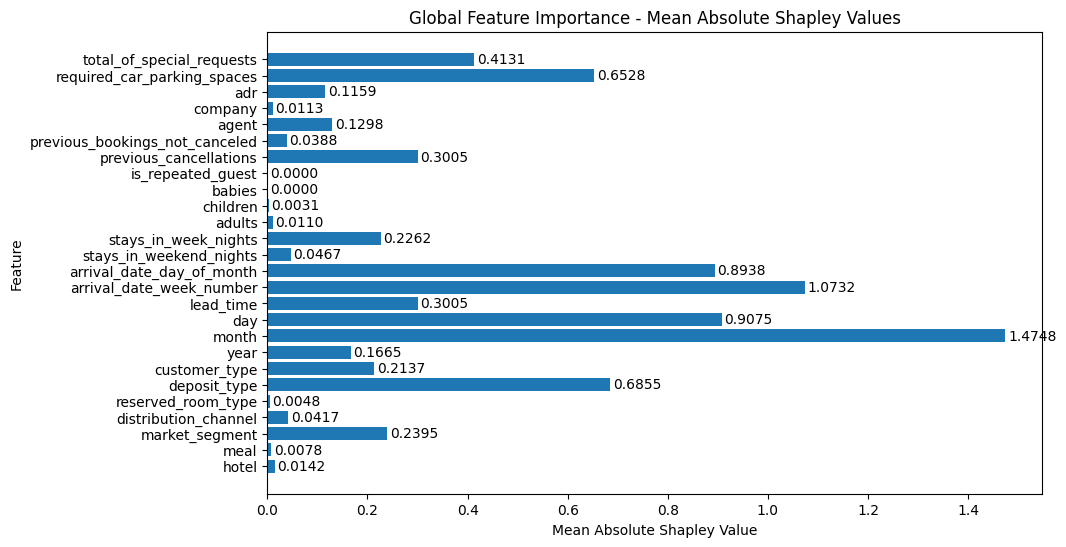

In [48]:
mean_shap_values = np.abs(shap_values.values).mean(axis=0)
feature_names = X_test_processed.columns

plt.figure(figsize=(10, 6))
bars = plt.barh(feature_names, mean_shap_values)
plt.xlabel('Mean Absolute Shapley Value')
plt.ylabel('Feature')
plt.title('Global Feature Importance - Mean Absolute Shapley Values')

for bar, value in zip(bars, mean_shap_values):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, '{:.4f}'.format(value), va='center')

plt.show()

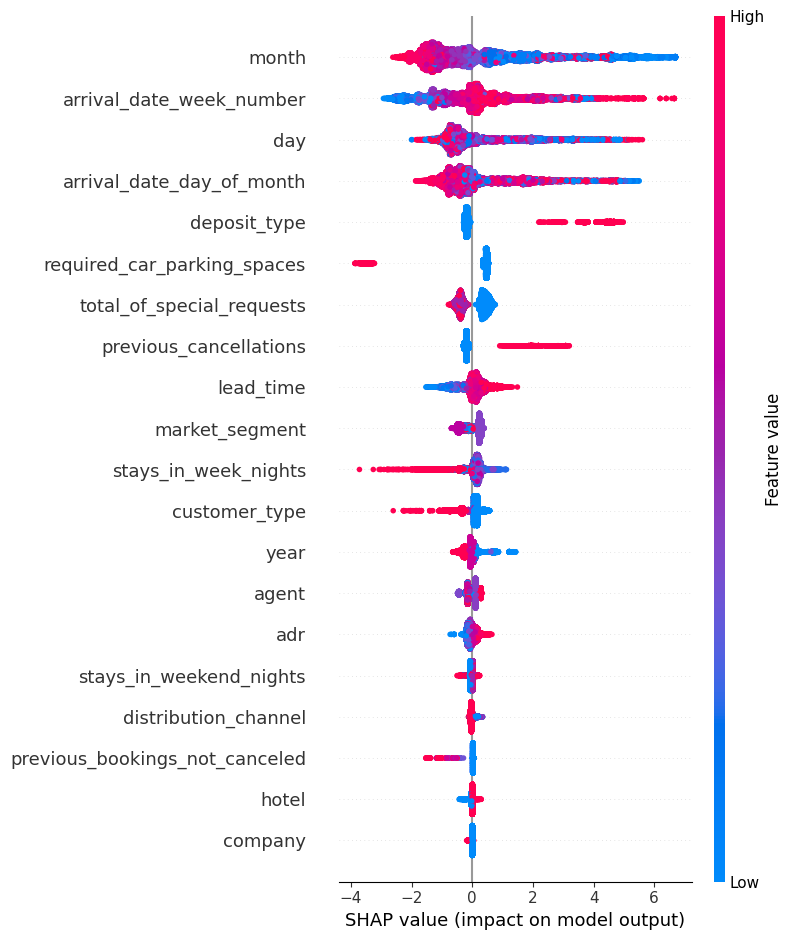

In [46]:
shap.summary_plot(shap_values, X_test_processed)